# SST

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import xarray as xr
from scipy.interpolate import griddata
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import hvplot.xarray 

## Data
- select monthly SST from 2011-2022

In [2]:
months = 12*12

data_mask = xr.open_dataset('../observations_sst/lsmask.nc')
mask = data_mask.mask                     
mask = mask.sel(lat=slice(60.0, -60.0))   
mask = mask.squeeze()

observations = xr.open_dataset('../observations_sst/sst.mnmean.nc')
observations = observations.sst.sel(time=slice("2011","2022")).where(mask == 1.) 

mesh = xr.open_dataset('../model_mesh/orca05l75_domain_cfg_nemov5_10m.nc')
lonf = mesh['glamf'].values
latf = mesh['gphif'].values

model = xr.open_dataset('../model_output/nemo00_1m_201001_202212_grid_T.nc')
model = model.tos.sel(time_counter=slice("2011","2022")) 
lat_row_max = latf.max(axis=1)
lat_row_min = latf.min(axis=1)
valid_y = np.where((lat_row_min >= -60) & (lat_row_max <= 60))[0]
y_min, y_max = valid_y.min(), valid_y.max()
model = model.isel(y=slice(y_min, y_max + 1))
latf = latf[y_min:y_max + 1, :]
lonf = lonf[y_min:y_max + 1, :]

In [3]:
data_mask

<xarray.Dataset> Size: 175kB
Dimensions:  (time: 1, lon: 360, lat: 120)
Coordinates:
  * time     (time) datetime64[ns] 8B 1981-10-29
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float32 480B 59.5 58.5 57.5 56.5 ... -56.5 -57.5 -58.5 -59.5
Data variables:
    mask     (time, lat, lon) float32 173kB ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    source:       NCEP Climate Modeling Branch
    institution:  National Centers for Environmental Prediction
    title:        NOAA Optimum Interpolation (OI) SST V2
    history:      Sun Jan 15 21:48:12 2023: cdo sellonlatbox,0,360,-60,60 lsm...
    comments:     Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmith...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [4]:
observations

<xarray.DataArray 'sst' (time: 144, lat: 120, lon: 360)> Size: 25MB
array([[[ 7.47      ,  7.0699997 ,  6.6299996 , ...,  8.099999  ,
          8.01      ,  7.83      ],
        [ 7.24      ,  6.89      ,  6.49      , ...,  7.6499996 ,
          7.5499997 ,  7.4199996 ],
        [ 7.1       ,  6.85      ,  6.5       , ...,  7.3399997 ,
          7.22      ,  7.16      ],
        ...,
        [ 0.09      ,  0.11      ,  0.12      , ...,  0.08      ,
          0.04      ,  0.05      ],
        [-0.02      ,  0.        ,  0.        , ..., -0.14999999,
         -0.14999999, -0.09999999],
        [-0.08      , -0.07      , -0.08      , ..., -0.26      ,
         -0.22      , -0.16      ]],

       [[ 7.1099997 ,  6.7       ,  6.19      , ...,  7.54      ,
          7.49      ,  7.3799996 ],
        [ 6.77      ,  6.48      ,  6.08      , ...,  7.        ,
          6.94      ,  6.89      ],
        [ 6.6099997 ,  6.43      ,  6.12      , ...,  6.71      ,
          6.6299996 ,  6.6299996 ],
...
        [-0.89      , -0.91999996, -0.96999997, ..., -0.87      ,
         -0.88      , -0.89      ],
        [-1.24      , -1.28      , -1.31      , ..., -1.1999999 ,
         -1.1999999 , -1.2099999 ],
        [-1.51      , -1.54      , -1.56      , ..., -1.49      ,
         -1.48      , -1.48      ]],

       [[ 9.83      ,  9.49      ,  9.25      , ..., 10.36      ,
         10.28      , 10.09      ],
        [ 9.78      ,  9.4       ,  9.11      , ..., 10.5       ,
         10.33      , 10.09      ],
        [ 9.55      ,  9.23      ,  9.        , ..., 10.32      ,
         10.059999  ,  9.809999  ],
        ...,
        [-0.11      , -0.16      , -0.19999999, ..., -0.13      ,
         -0.11      , -0.12      ],
        [-0.42      , -0.44      , -0.48      , ..., -0.48      ,
         -0.45      , -0.45      ],
        [-0.72999996, -0.72999996, -0.75      , ..., -0.82      ,
         -0.78      , -0.75      ]]], shape=(144, 120, 360), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2011-01-01 2011-02-01 ... 2022-12-01
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float32 480B 59.5 58.5 57.5 56.5 ... -56.5 -57.5 -58.5 -59.5
Attributes:
    standard_name:         sea_surface_temperature
    long_name:             Monthly Mean of Sea Surface Temperature
    units:                 degC
    unpacked_valid_range:  [-5. 40.]
    actual_range:          [-1.7999996 35.56862  ]
    precision:             2
    var_desc:              Sea Surface Temperature
    dataset:               NOAA Optimum Interpolation (OI) SST V2
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Weekly Mean
    cell_methods:          time: mean (monthly from weekly values interpolate...

In [5]:
mesh

<xarray.Dataset> Size: 2GB
Dimensions:       (y: 510, x: 720, nav_lev: 75, nlines: 54)
Coordinates:
  * nav_lev       (nav_lev) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x, nlines
Data variables: (12/33)
    e1v           (y, x) float64 3MB ...
    e2u           (y, x) float64 3MB ...
    nav_lon       (y, x) float32 1MB ...
    nav_lat       (y, x) float32 1MB ...
    glamt         (y, x) float64 3MB ...
    glamu         (y, x) float64 3MB ...
    ...            ...
    e3uw_0        (nav_lev, y, x) float64 220MB ...
    e3vw_0        (nav_lev, y, x) float64 220MB ...
    bottom_level  (y, x) int32 1MB ...
    top_level     (y, x) int32 1MB ...
    bathy_metry   (y, x) float64 3MB ...
    namelist_cfg  (nlines) |S102 6kB ...
Attributes:
    history:      Tue Sep 10 21:54:46 2024: ncap2 -O --ftn -s           /* Gi...
    CfgName:      ORCA
    CfgIndex:     5
    Iperio:       1
    Jperio:       0
    NFold:        1
    NFtype:       F
    VertCoord:    zps
    IsfCav:       0
    NEMOversion:  5.0
    NCO:          netCDF Operators version 5.2.8 (Homepage = http://nco.sf.ne...

In [6]:
model
print("min lon:", model.nav_lon.values.min())
print("max lon:", model.nav_lon.values.max())

min lon: -179.98898
max lon: 179.99754


## Plot

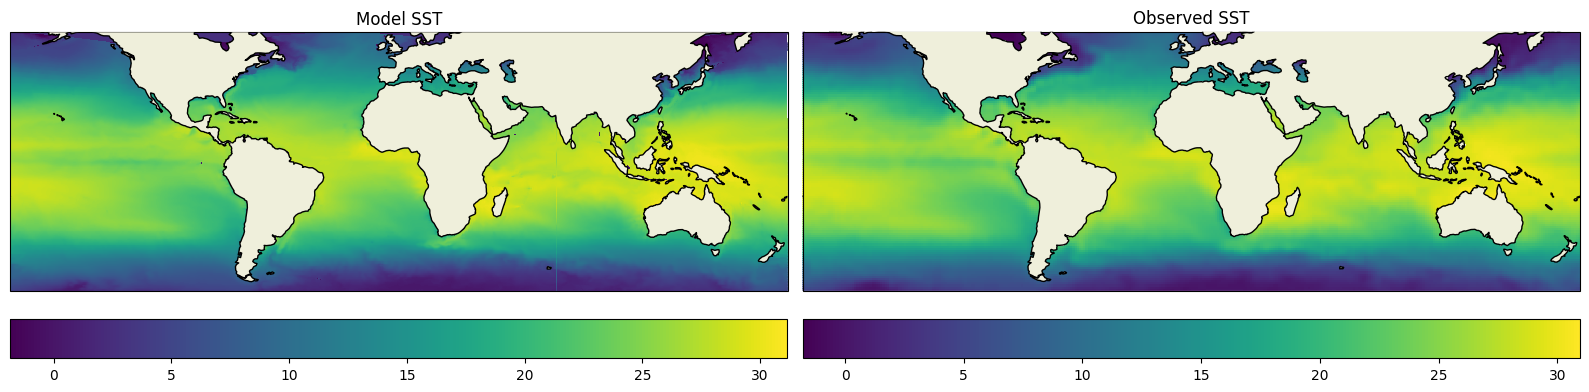

In [7]:
# Take one time slice
sst_model_2d = model.values[0, :, :]
sst_obs_2d = observations.values[0, :, :]

obs_lon = observations.lon
obs_lat = observations.lat

# Plot setup
fig, axes = plt.subplots(ncols=2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# --- Model Plot ---
ax = axes[0]
cs = ax.pcolormesh(lonf, latf, sst_model_2d[1:,1:], transform=ccrs.PlateCarree(), shading='flat')
ax.set_title("Model SST")
ax.add_feature(cfeature.LAND, zorder=50)
ax.add_feature(cfeature.COASTLINE, zorder=51)
fig.colorbar(cs, ax=ax, orientation='horizontal', pad=0.05)

# --- Observation Plot ---
ax = axes[1]
cs = ax.pcolormesh(obs_lon, obs_lat, sst_obs_2d, transform=ccrs.PlateCarree())
ax.set_title("Observed SST")
ax.add_feature(cfeature.LAND, zorder=50)
ax.add_feature(cfeature.COASTLINE, zorder=51)
fig.colorbar(cs, ax=ax, orientation='horizontal', pad=0.05)

plt.tight_layout()

In [8]:
# Plot model SST
plot_model = model.isel(time_counter=slice(1, months+1)).hvplot.image(
    x='x', y='y', cmap='jet', clim=(0, 30), title='Model SST', frame_width=400)

# Plot observation SST
plot_obs = observations.isel(time=slice(1, months+1)).hvplot.image(
    x='lon', y='lat', cmap='jet', clim=(0, 30), title='Observed SST', frame_width=400)

# Combine side by side
(plot_model + plot_obs).cols(1)

:Layout
   .DynamicMap.I  :DynamicMap   [time_counter]
      :Image   [x,y]   (sea_surface_temperature)
   .DynamicMap.II :DynamicMap   [time]
      :Image   [lon,lat]   (Monthly Mean of Sea Surface Temperature)

In [12]:
# Select time index to compare
time_idx = 12

# Convert model longitudes from [-180, 180] to [0, 360)
model_lon_360 = (model.nav_lon.values + 360) % 360

# Flatten model grid and extract SST values
points = np.column_stack((model_lon_360.flatten(), model.nav_lat.values.flatten()))
values = model.isel(time_counter=time_idx).values.flatten()

# Generate meshgrid for observation coordinates
obs_lon, obs_lat = np.meshgrid(observations.lon.values, observations.lat.values)

# Interpolate model SST onto observation grid
model_interp = griddata(points, values, (obs_lon, obs_lat), method='linear')

# Compute SST error on observation grid
error = model_interp - observations.isel(time=time_idx).values

# Wrap error in xarray for convenient plotting
error_xr = xr.DataArray(
    error,
    dims=('lat', 'lon'),
    coords={'lat': observations.lat, 'lon': observations.lon},
    name='SST_Error'
)

# Plot the error map
error_xr.hvplot.image(
    x='lon', y='lat',
    cmap='RdBu_r',
    clim=(-5, 5),
    title='SST Error (Model - Observation)',
    frame_width=600
)

:Image   [lon,lat]   (SST_Error)